## Project 1 (Due 2/17)

The goal of the first project is to do some wrangling, EDA, and visualization, and generate sequences of values. We will focus on:

- CDC National Health and Nutritional Examination Survey (NHANES, 1999-2000): https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=1999
- CDC Linked Mortality File (LMF, 1999-2000): https://www.cdc.gov/nchs/data-linkage/mortality-public.htm

NHANES is a rich panel dataset on health and behavior, collected bi-yearly from around 1999 to now. We will focus on the 1999 wave, because that has the largest follow-up window, providing us with the richest mortality data. The mortality data is provided by the CDC Linked Mortality File.

The purpose of the project is to use $k$-NN to predict who dies (hard or soft classification) and how long they live (regression).

### Day 1: Wrangling and EDA (40/100 pts)

First, go to the NHANES and LMF web sites and familiarize yourself with the data sources. Download codebooks. Think about what resources are available. The CDC Linked Mortality File is somewhat of a pain to work with, so I have pre-cleaned it for you. It is available at httts://github.com/ds4e/undergraduate_ml_assignments in the data folder, as `lmf_parsed.cav`. From the CDC LMF web page, get the SAS program to load the data; it is the real codebook.

Second, download the demographic data for the 1999--2000 wave from the NHANES page. You can use the following code chunk to merge the LMF and DEMO data:

``` python
import pandas as pd
mdf = pd.read_csv('lmf_parsed.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable
```

Third, the variables `ELIGSTAT`, `MORTSTAT`, `PERMTH_INT`, and `RIDAGEEX` are particularly important. Look them up in the documentation and clearly describe them. (5/100 pts.)

Second, the goal of the project is to use whatever demographic, behavioral, and health data you like to predict mortality (`MORTSTAT`) and life expectancy (`PERMTH_INT`). Go to the NHANES 1999--2000 web page and select your data and download it. Clearly explain your rationale for selecting these data. Use `.merge` to combine your data into one complete dataframe. Document missing values. (5/100 pts)

Third, do basic EDA and visualization of the key variables. Are any important variables skewed? Are there outliers? How correlated are pairs of variables? Do pairs of categorical variables exhibit interesting patterns in contingency tables? Provide a clear discussion and examination of the data and the variables you are interested in using. (20/100 pts)


### Day 2: $k$-NN classification/regression, write-up (50/100 pts)

Submit a notebook that clearly addresses the following, using code and markdown chunks:

1. Describe the data, particularly what an observation is and whether there are any missing data that might impact your analysis. Who collected the data and why? What known limitations are there to analysis? (10/100 pts)
2. Describe the variables you selected to predict mortality and life expectancy, and the rationale behind them. Analyze your variables using describe tables, kernel densities, scatter plots, and conditional kernel densities. Are there any patterns of interest to notice? (10/100 pts)
3. Using your variables to predict mortality using a $k$-Nearest Neighbor Classifier. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
4. Using your variables to predict life expectancy using a $k$-Nearest Neighbor Regressor. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
5. Describe how your model could be used for health interventions based on patient characteristics. Are there any limitations or risks to consider? (10/100 pts)

## Submission (10/100 pts)

Submit your work in a well-organized GitHub repo, where the code is appropriately commented and all members of the group have made significant contributions to the commit history. (10/100 pts)

### Submission: Day 1

First we begin with loading the two datasets (DEMO.xpt and linked_mortality_file_1999_2000.csv)

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
!git clone https://github.com/kenny507/undergrad_ml_assignments.git

Cloning into 'undergrad_ml_assignments'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 88 (delta 9), reused 3 (delta 3), pack-reused 72 (from 2)
Receiving objects: 100% (88/88), 9.76 MiB | 8.50 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [8]:
%cd undergrad_ml_assignments
!ls
!ls data

/content/undergrad_ml_assignments/undergrad_ml_assignments
01_assignment_wrangling_and_eda.ipynb  image2.png  image6.png
02_assignment_knn.ipynb		       image3.png  image.png
data				       image4.png  project_1_bsds.ipynb
get_data.py			       image5.png  README.md
DEMO.xpt
DUQ.xpt
linked_mortality_file_1999_2000.csv
public-use-linked-mortality-file-description.pdf
SAS_ReadInProgramAllSurveys.sas
SMQ.xpt


In [11]:
# Load linked mortality file and the DEMO.xpt file
mdf = pd.read_csv("data/linked_mortality_file_1999_2000.csv")
print("Mortality file:", mdf.shape)
print(mdf.head())
gdf = pd.read_sas("data/DEMO.xpt", format="xport")
print("Demo file:", gdf.shape)
print(gdf.head())
# Merge
df = gdf.merge(mdf, on="SEQN", how="inner")
print("Merged:", df.shape)
df.head()

Mortality file: (9965, 8)
   SEQN  ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0     1         2       NaN           NaN       NaN       NaN         NaN   
1     2         1       1.0           6.0       0.0       0.0       177.0   
2     3         2       NaN           NaN       NaN       NaN         NaN   
3     4         2       NaN           NaN       NaN       NaN         NaN   
4     5         1       0.0           NaN       NaN       NaN       244.0   

   PERMTH_EXM  
0         NaN  
1       177.0  
2         NaN  
3         NaN  
4       244.0  
Demo file: (9965, 144)
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0 

,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,WTIREP50,WTIREP51,WTIREP52,ELIGSTAT,MORTSTAT,UCOD_LEADING,DIABETES,HYPERTEN,PERMTH_INT,PERMTH_EXM
0,1.0,1.0,2.0,2.0,2.0,2.0,29.0,31.0,4.0,2.0,...,10327.992682,9809.165049,10323.315747,2,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,27268.025234,27406.383620,26984.812909,1,1.0,6.0,0.0,0.0,177.0,177.0
2,3.0,1.0,2.0,1.0,2.0,10.0,125.0,126.0,3.0,1.0,...,44480.987235,45389.112766,43781.905637,2,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,1.0,2.0,2.0,1.0,1.0,22.0,23.0,4.0,2.0,...,10851.024385,10564.981435,11012.529729,2,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,92817.926915,94282.855382,91993.251203,1,0.0,NaN,NaN,NaN,244.0,244.0


1. `ELIGSTAT`:This variable tells you whether a survey participant was eligible to be linked to mortality (death) records in the National Death Index (NDI):

1 = Eligible: The participant had sufficient identifying information to be linked to death records.

2 = Under age 18 (not released): The participant was under age 18 and thus not included in the public-use mortality linkage.

3 = Ineligible: The participant did not have enough identifying information to perform the mortality linkage.

2. `MORTSTAT` :This variable indicates the vital status of a participant (whether they are counted as alive or deceased) after linkage to mortality data:

0 = Assumed alive: The participant was eligible for linkage and was not found to be deceased in the linked mortality data.

1 = Assumed deceased: The participant was eligible and a match to a death record was found.

Blank/missing: Not eligible for linkage (e.g., too young or insufficient records).

3. `PERMTH_INT`: This variable measures the total number of months the participant was followed for mortality outcomes starting from the survey interview date until:

the date of death, if deceased; or

the end of the mortality follow-up period (e.g., Dec 31, 2019 for public-use linked data).

4. `RIDAGEEX` : The age of the respondent at the time of their NHANES examination in months.

In [12]:
smq = pd.read_sas("data/SMQ.xpt", format="xport")
print("Smoking file:", smq.shape)

duq = pd.read_sas("data/DUQ.xpt", format="xport")
print("Drug Use file:", duq.shape)

df = df.merge(smq, on="SEQN", how="left")
df = df.merge(duq, on="SEQN", how="left")

print("Final merged dataset:", df.shape)


Smoking file: (4880, 39)
Drug Use file: (2838, 5)
Final merged dataset: (9965, 193)


In [13]:
print(df.isna().sum())

SEQN           0
SDDSRVYR       0
RIDSTATR       0
RIDEXMON     683
RIAGENDR       0
            ... 
SMD235      9945
DUQ100      7360
DUQ110      9483
DUQ120      9483
DUQ130      9914
Length: 193, dtype: int64


We chose Drug Use and Smoking because we wanted to see how much these impact mortality rates and life expectancy.

1. `DUQ100` (renamed to `used_street_drug`): Ever used cocaine or other street drugs, not including marijuana:
   
   1 = Yes

   2 = No

   7 = Refused

   9 = Don't know

2. `SMQ020` (renamed to `smoked_cigarettes`): Smoked at least 100 cigarettes in life
   
   1 = Yes

   2 = No

   7 = Refused

   9 = Don't know

3. `SMQ150` (renamed to `smoked_cigars`): Smoked cigars at least 20 times in life
   
   1 = Yes

   2 = No

   7 = Refused

   9 = Don't know

4. `SMQ210` (renamed to `used_chewing_tobacco`): Used chewing tobacco at least 20 times in life
   
   1 = Yes

   2 = No

   7 = Refused

   9 = Don't know

In [14]:
# filtering out records that are not eligible for linkage (without a valid MORTSTAT)
df_linked = df[df["MORTSTAT"].notna()]
print(df_linked.shape)
df_linked.head()

(5445, 193)


,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,SMQ205,SMQ210,SMD220,SMQ230,SMD233,SMD235,DUQ100,DUQ110,DUQ120,DUQ130
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,NaN,1.0,5.397605e-79,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,6.0,1.0,2.0,2.0,2.0,19.0,230.0,230.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,1.0,2.0,2.0,2.0,59.0,712.0,712.0,4.0,2.0,...,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
9,10.0,1.0,2.0,2.0,1.0,43.0,518.0,518.0,4.0,2.0,...,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN


#### Age

In [15]:
print(df_linked["RIDAGEEX"].isna().sum() / df_linked.shape[0])

0.1111111111111111


In [16]:
df_age_notna = df_linked[df_linked["RIDAGEEX"].notna()]
((df_age_notna["RIDAGEEX"] // 12) - df_age_notna["RIDAGEYR"]).value_counts()

,count
0.0,4494
1.0,346


Records with missing `RIDAGEEX` values account for only 11% of the data. Additionally, for records with a `RIDAGEEX` value, that value only differs from `RIDAGEYR` by at most one year. Therefore, we set the `CLEANED_AGE` of each patient to be `RIDAGEEX` in years, and if this value is missing, then set to `RIDAGEYR`.

In [17]:
df_linked["CLEANED_AGE"] = np.where(df_linked["RIDAGEEX"].notna(), df_linked["RIDAGEEX"] // 12, df_linked["RIDAGEYR"])
df_linked.head()

/tmp/ipython-input-2158176905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["CLEANED_AGE"] = np.where(df_linked["RIDAGEEX"].notna(), df_linked["RIDAGEEX"] // 12, df_linked["RIDAGEYR"])


,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,SMQ210,SMD220,SMQ230,SMD233,SMD235,DUQ100,DUQ110,DUQ120,DUQ130,CLEANED_AGE
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,1.0,5.397605e-79,NaN,NaN,NaN,2.0,NaN,NaN,NaN,49.0
5,6.0,1.0,2.0,2.0,2.0,19.0,230.0,230.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0
6,7.0,1.0,2.0,2.0,2.0,59.0,712.0,712.0,4.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,59.0
9,10.0,1.0,2.0,2.0,1.0,43.0,518.0,518.0,4.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,43.0


In [18]:
df_linked["CLEANED_AGE"].describe()

,CLEANED_AGE
count,5445.000000
mean,47.264646
std,20.684510
min,18.000000
25%,29.000000
50%,45.000000
75%,65.000000
max,85.000000


<Axes: xlabel='CLEANED_AGE', ylabel='Count'>

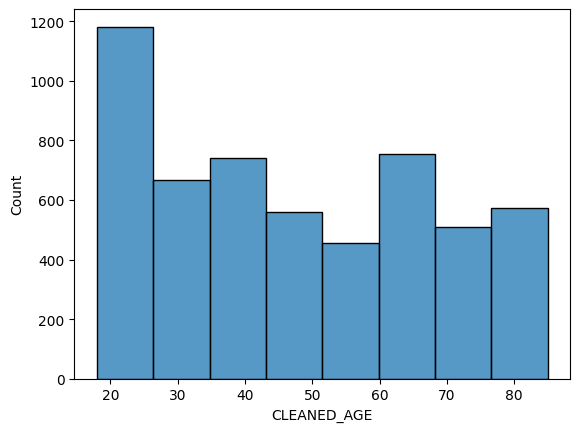

In [19]:
sns.histplot(df_linked["CLEANED_AGE"], bins=8)

Survey participant ages are skewed right, with a plurality of participants being around their early 20s.

#### Drug Use

From the drug use dataset `DUQ`, we used the feature `DUQ100`, cleaned and renamed as `used_street_drug`.

`DUQ100` was converted from float to string.

In [20]:
df_linked["DUQ100_na"] = df_linked["DUQ100"].isna()
df_linked["used_street_drug"] = np.where(df_linked["DUQ100"].notna(), df_linked["DUQ100"].astype("Int64").astype("str"), "Missing")

/tmp/ipython-input-2414763143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["DUQ100_na"] = df_linked["DUQ100"].isna()
/tmp/ipython-input-2414763143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["used_street_drug"] = np.where(df_linked["DUQ100"].notna(), df_linked["DUQ100"].astype("Int64").astype("str"), "Missing")


In [21]:
pd.crosstab(df_linked["MORTSTAT"], df_linked["used_street_drug"])

used_street_drug,1,2,7,9,Missing
MORTSTAT,,,,,
0.0,414,1898,5,6,1447
1.0,67,208,1,3,1396


<Axes: xlabel='PERMTH_INT', ylabel='Density'>

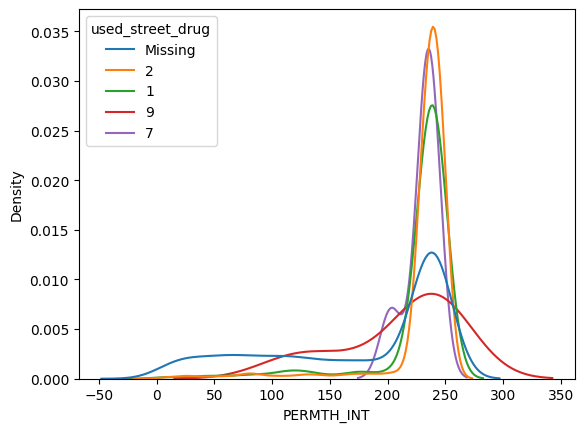

In [22]:
sns.kdeplot(df_linked, x="PERMTH_INT", hue="used_street_drug", common_norm=False)

Of those participants who have never used street drugs (coded as 2), 90% of them are assumed alive. Of those particpants who have used street drugs (coded as 1), 86% of them are assumed alive.

Initial analysis indicates that drug use does not have a significant effect on mortality.

#### Smoking

From the smoking dataset `SMQ`, we used the features `SMQ020`, `SMQ150`, and `SMQ210`, cleaned and renamed as `smoked_cigarettes`, `smoked_cigars`, and `used_chewing_tobacco` respectively.

All were converted from float to string.

In [23]:
df_linked["SMQ020_na"] = df_linked["SMQ020"].isna()
df_linked["smoked_cigarettes"] = np.where(df_linked["SMQ020"].notna(), df_linked["SMQ020"].astype("Int64").astype("str"), "Missing")

/tmp/ipython-input-877426205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["SMQ020_na"] = df_linked["SMQ020"].isna()
/tmp/ipython-input-877426205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["smoked_cigarettes"] = np.where(df_linked["SMQ020"].notna(), df_linked["SMQ020"].astype("Int64").astype("str"), "Missing")


In [24]:
df_linked["SMQ150_na"] = df_linked["SMQ150"].isna()
df_linked["smoked_cigars"] = np.where(df_linked["SMQ150"].notna(), df_linked["SMQ150"].astype("Int64").astype("str"), "Missing")

/tmp/ipython-input-3165175500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["SMQ150_na"] = df_linked["SMQ150"].isna()
/tmp/ipython-input-3165175500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["smoked_cigars"] = np.where(df_linked["SMQ150"].notna(), df_linked["SMQ150"].astype("Int64").astype("str"), "Missing")


In [25]:
df_linked["SMQ210_na"] = df_linked["SMQ210"].isna()
df_linked["used_chewing_tobacco"] = np.where(df_linked["SMQ210"].notna(), df_linked["SMQ210"].astype("Int64").astype("str"), "Missing")

/tmp/ipython-input-3402285081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["SMQ210_na"] = df_linked["SMQ210"].isna()
/tmp/ipython-input-3402285081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["used_chewing_tobacco"] = np.where(df_linked["SMQ210"].notna(), df_linked["SMQ210"].astype("Int64").astype("str"), "Missing")


In [26]:
df_linked.head()

,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,DUQ130,CLEANED_AGE,DUQ100_na,used_street_drug,SMQ020_na,smoked_cigarettes,SMQ150_na,smoked_cigars,SMQ210_na,used_chewing_tobacco
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,NaN,77.0,True,Missing,False,2,False,1,False,2
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,NaN,49.0,False,2,False,1,False,1,False,1
5,6.0,1.0,2.0,2.0,2.0,19.0,230.0,230.0,5.0,4.0,...,NaN,19.0,True,Missing,True,Missing,True,Missing,True,Missing
6,7.0,1.0,2.0,2.0,2.0,59.0,712.0,712.0,4.0,2.0,...,NaN,59.0,False,2,False,1,False,2,False,2
9,10.0,1.0,2.0,2.0,1.0,43.0,518.0,518.0,4.0,2.0,...,NaN,43.0,False,2,False,1,False,2,False,2


In [27]:
for feature in ["smoked_cigarettes", "smoked_cigars", "used_chewing_tobacco"]:
    print(pd.crosstab(df_linked["MORTSTAT"], df_linked[feature]))

smoked_cigarettes     1     2  7  9  Missing
MORTSTAT                                    
0.0                1369  1840  1  4      556
1.0                 928   725  3  4       15
smoked_cigars    1     2  7  9  Missing
MORTSTAT                               
0.0            316  2896  1  1      556
1.0            266  1388  3  3       15
used_chewing_tobacco    1     2  7  9  Missing
MORTSTAT                                      
0.0                   117  3095  1  1      556
1.0                   106  1548  3  3       15


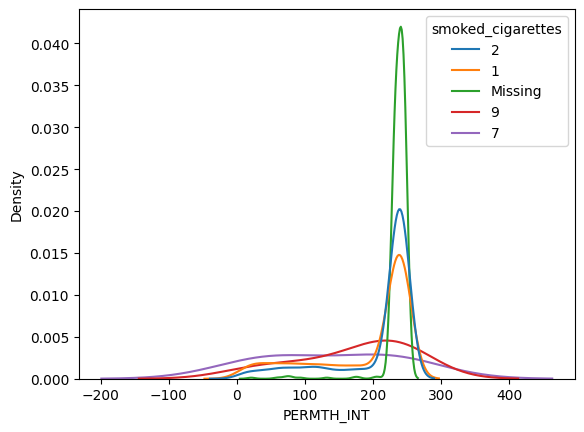

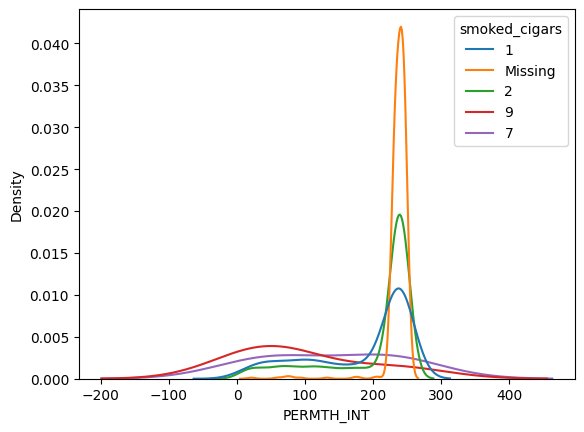

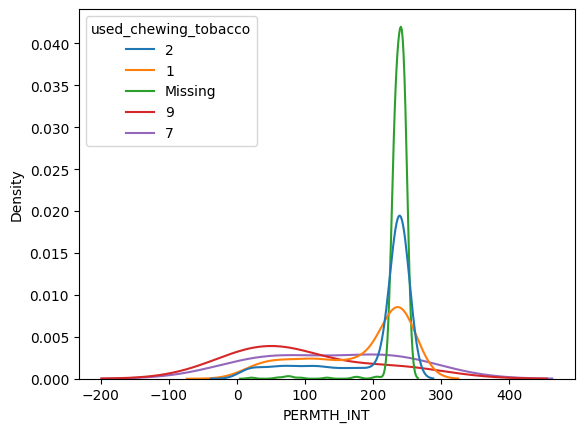

In [28]:
for feature in ["smoked_cigarettes", "smoked_cigars", "used_chewing_tobacco"]:
    sns.kdeplot(df_linked, x="PERMTH_INT", hue=feature, common_norm=False)
    plt.show()

When it comes to participants who have smoked before, those who have smoked over 100 cigarettes seem to have the most significant difference in mortality.

Of those particpants who have smoked over 100 cigarettes in their life, 40% of them are assumed dead. Of those participants who have not smoked over 100 cigarettes in their life, 28% of them are assumed dead. These are similar statistics for cigar smokers and chewing tobacco users as well. Of thse who have smoked more, a higher percentage are assumed dead.

Initial analysis indicates that smoking, or at least smoking excessively, is correlated with mortality.

### Submission Day 2

**Question 1:**

One observation is one NHANES participant (unique `SEQN`) from the 1999–2000 wave. NHANES is collected by the CDC’s National Center for Health Statistics to measure the health and nutrition status of the U.S. population. The LMF links NHANES participants to National Death Index mortality records to enable research on mortality outcomes. There are missing data that impacts the analysis since `MORTSTAT` and `PERMTH_INT` are only observed when `ELIGSTAT==1`. Thus, modeling is only done on the portion of samples that is eligible.

This analysis has several potential limitations. First, mortality outcomes are only available for participants who are eligible for linkage (`ELIGSTAT = 1`), so the models are trained on a restricted subset and may not be generalize to everyone in the survey. Secondly, several predictors  can be self-reported, so measurement error and underreporting can weaken model accuracy. Finally, these models capture correlations, not causation. So it is possible that differences in predicted mortality risk may reflect socioeconomic factors and access to care, rather than biological effects.

**Question 2:**

The variables we used to predict mortality and life expectancy include: age(`CLEANED_AGE`), drug use(`used_street_drug`), and smoking indicators( `smoked_cigarettes`, `smoked_cigars`, and `used_chewing_tobacco`).

We selected age because it is the strongest baseline driver of mortality risk and survival time: all else equal, older individuals have had more time to accumulate chronic disease and are closer to the end of life. We selected smoking variables because cigarette, cigar, and chewing tobacco use capture long-run exposure to harmful substances. For example carcinogens may lead to  cardiovascular risks. Therefore smoking variables should be associated with higher mortality risk and shorter follow-up. We selected drug use because it proxies risky behavior and potential long-run health harms that can increase the probability of death and reduce survival time. Together, these variables give a simple but plausible set of predictors that combine a strong biological baseline factor (age) with behavioral risk factors (tobacco and drug use) that are clinically and epidemiologically linked to mortality outcomes.

In [29]:
# keeping only what we will analyze
df_q2 = df_linked[[
    "MORTSTAT", "PERMTH_INT", "CLEANED_AGE",
    "used_street_drug", "smoked_cigarettes", "smoked_cigars", "used_chewing_tobacco"
]].copy()

In [30]:
# Describe tables
df_q2[["CLEANED_AGE", "PERMTH_INT"]].describe()

,CLEANED_AGE,PERMTH_INT
count,5445.000000,5445.000000
mean,47.264646,202.314601
std,20.684510,67.137767
min,18.000000,0.000000
25%,29.000000,194.000000
50%,45.000000,235.000000
75%,65.000000,242.000000
max,85.000000,250.000000


In [31]:
# Outcome balance
df_q2["MORTSTAT"].value_counts(dropna=False)

,count
MORTSTAT,
0.0,3770
1.0,1675


In [32]:
# Predictor category counts
for v in ["used_street_drug", "smoked_cigarettes", "smoked_cigars", "used_chewing_tobacco"]:
    print("\n", v)
    print(df_q2[v].value_counts(dropna=False))


 used_street_drug
used_street_drug
Missing    2843
2          2106
1           481
9             9
7             6
Name: count, dtype: int64

 smoked_cigarettes
smoked_cigarettes
2          2565
1          2297
Missing     571
9             8
7             4
Name: count, dtype: int64

 smoked_cigars
smoked_cigars
2          4284
1           582
Missing     571
9             4
7             4
Name: count, dtype: int64

 used_chewing_tobacco
used_chewing_tobacco
2          4643
Missing     571
1           223
9             4
7             4
Name: count, dtype: int64


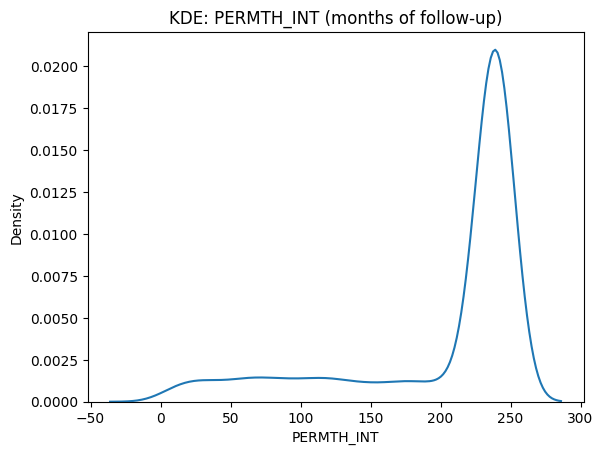

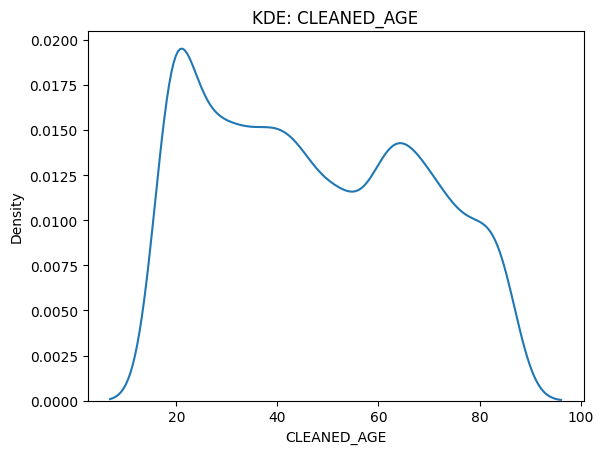

In [33]:
# KDE for PERMTH_INT
plt.figure()
sns.kdeplot(data=df_q2, x="PERMTH_INT")
plt.title("KDE: PERMTH_INT (months of follow-up)")
plt.show()

# KDE for age
plt.figure()
sns.kdeplot(data=df_q2, x="CLEANED_AGE")
plt.title("KDE: CLEANED_AGE")
plt.show()




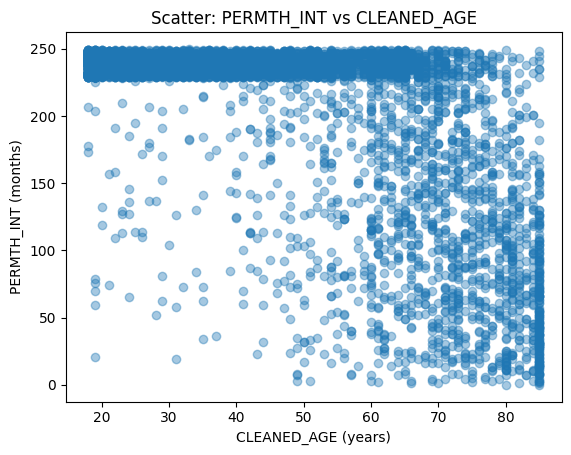

In [ ]:
plt.figure()
plt.scatter(df_q2["CLEANED_AGE"], df_q2["PERMTH_INT"], alpha=0.4)
plt.xlabel("CLEANED_AGE (years)")
plt.ylabel("PERMTH_INT (months)")
plt.title("Scatter: PERMTH_INT vs CLEANED_AGE")
plt.show()

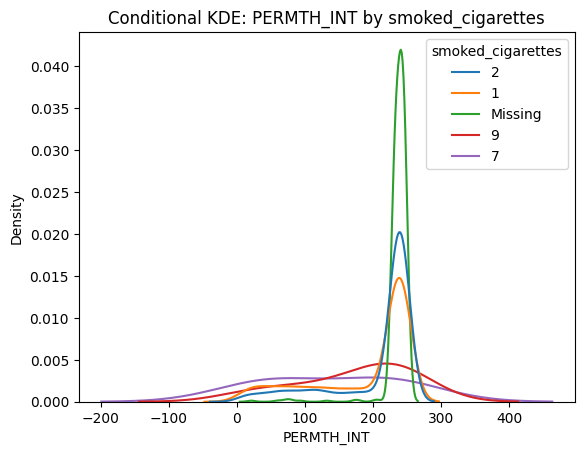

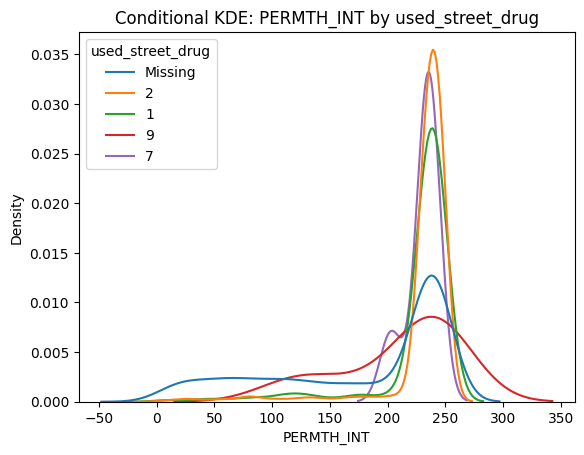

In [ ]:
plt.figure()
sns.kdeplot(data=df_q2, x="PERMTH_INT", hue="smoked_cigarettes", common_norm=False)
plt.title("Conditional KDE: PERMTH_INT by smoked_cigarettes")
plt.show()

plt.figure()
sns.kdeplot(data=df_q2, x="PERMTH_INT", hue="used_street_drug", common_norm=False)
plt.title("Conditional KDE: PERMTH_INT by used_street_drug")
plt.show()

**Noticeable Patterns of Interest:**

1. A pattern that we've noticed is in the `PERMTH_INT` itself. The KDE shows a very large spike near the upper end (around 240–250 months), meaning many participants have follow-up times close to the maximum window, while a smaller group has much shorter follow-up. This is consistent with many people being observed until the end of the study period, and shorter follow-up mainly happening for people who die earlier.

2. Another noticeable pattern is the relationship between age and `PERMTH_INT`. In the scatter plot, older participants show more low values than younger participants, which is consistent with higher mortality risk at older ages. At the same time, the thick horizontal band near at the top appears across all ages, reflecting the many people who reach the end of follow-up.

3. For the behavior variables, the only reasonably clear pattern is that the `smoked_cigarettes` vs `PERMTH_INT` conditional KDE suggests smokers have slightly more density at lower follow-up times than non-smokers, but there is still substantial overlap, so smoking alone does not separate outcomes cleanly. For drug use, the conditional KDEs overlap heavily so we would not claim any clear patterns.

**Question 3**

In [35]:
y = df["MORTSTAT"]
X = df[["RIDAGEYR", "RIAGENDR"]]

data = df[["MORTSTAT", "RIDAGEYR", "RIAGENDR"]].dropna()

y_clean = data["MORTSTAT"]
X_clean = data[["RIDAGEYR", "RIAGENDR"]]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    random_state=42,
    stratify=y_clean
)

In [37]:
means = X_train.mean()
stds = X_train.std()

X_train_scaled = (X_train - means) / stds
X_test_scaled = (X_test - means) / stds

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = range(1, 301)
test_acc = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    preds = knn.predict(X_test_scaled)
    test_acc.append(accuracy_score(y_test, preds))

Best k: 45 Best test accuracy: 0.8677685950413223


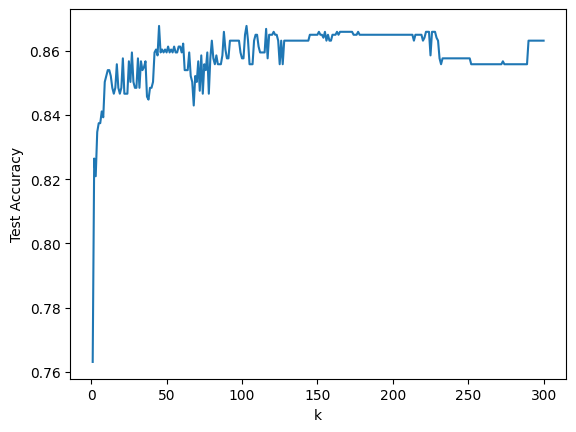

In [46]:
import numpy as np
import matplotlib.pyplot as plt

best_k = list(k_values)[int(np.argmax(test_acc))]
print("Best k:", best_k, "Best test accuracy:", max(test_acc))

plt.plot(list(k_values), test_acc)
plt.xlabel("k")
plt.ylabel("Test Accuracy")
plt.show()

We did a train-test split of 80-20. The accuracy significantly increases from 1 to 10 k. We selected k by assigning k from a range of 1 to 300. From the plot above, you can see that 45 had the best accuracy score. The accuracy stays roughly the same from 100 to 300. Overall, our variables are relatively good at predicting mortality.

**Question 4**

In [52]:
y = df["PERMTH_INT"]
X = df[["RIDAGEYR", "RIAGENDR"]]

data = df[["PERMTH_INT", "RIDAGEYR", "RIAGENDR"]].dropna()

y_clean = data["PERMTH_INT"]
X_clean = data[["RIDAGEYR", "RIAGENDR"]]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    random_state=42
)

In [53]:
means = X_train.mean()
stds = X_train.std()

X_train_scaled = (X_train - means) / stds
X_test_scaled = (X_test - means) / stds

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = range(1, 501)
test_acc = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    preds = knn.predict(X_test_scaled)
    test_acc.append(accuracy_score(y_test, preds))

Best k: 185 Best test accuracy: 0.04224058769513315


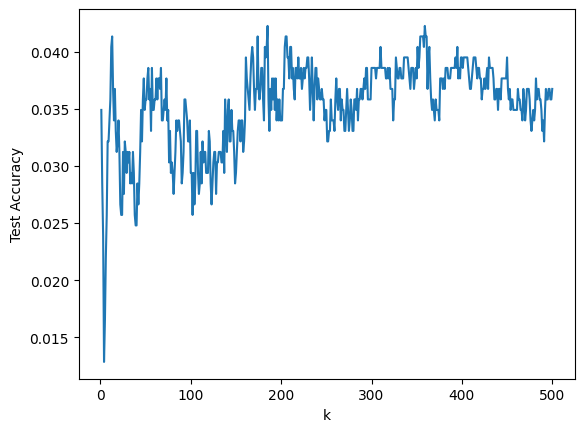

In [59]:
import numpy as np
import matplotlib.pyplot as plt

best_k = list(k_values)[int(np.argmax(test_acc))]
print("Best k:", best_k, "Best test accuracy:", max(test_acc))

plt.plot(list(k_values), test_acc)
plt.xlabel("k")
plt.ylabel("Test Accuracy")
plt.show()

We again used a train-test split of 80-20. The accuracy score varied a lot, so we increased the range for k to 501. The most accurate k value was 185, but the accuracy score was very low for all values. Overall, our variables are not good at predicting life expectancy.